In [1]:
from phi.torch.flow import *

C:\Users\imeho\Documents\VituralEnvs\InstantPINF-TCNN\Lib\site-packages\phi\vis\_matplotlib\_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


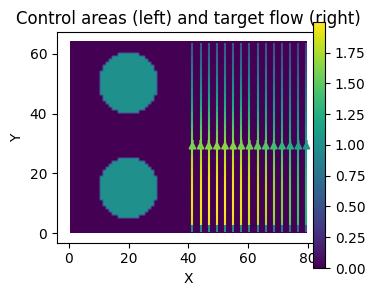

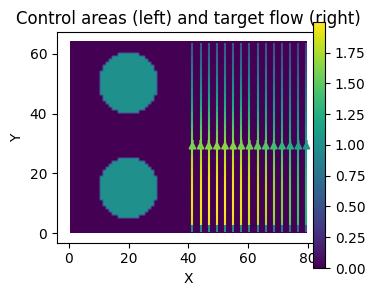

In [2]:
res = dict(x=80, y=64)
control_area = union(Sphere(x=20, y=15, radius=10), Sphere(x=20, y=50, radius=10))
control_mask = StaggeredGrid(control_area, 0, **res)
target_mask = StaggeredGrid(Box(x=(40, INF), y=None), 0, **res)
target = target_mask * StaggeredGrid(lambda x: math.exp(-0.5 * math.vec_squared(x - (50, 10), 'vector') / 32**2), 0, **res) * (0, 2)
plot(control_mask['x'], target, overlay='args', size=(4, 3), title='Control areas (left) and target flow (right)')

In [3]:
@jit_compile
def loss(v0):
    v1, p = fluid.make_incompressible(v0 * control_mask)
    return field.l2_loss((v1 - target) * target_mask), v1, p

grad_fun = field.functional_gradient(loss, wrt='v0', get_output=True)

In [7]:
from tqdm.notebook import trange
def gradient_descent_step(v0, _l, _v, step_size=1.):
    (loss, v, p), dv0 = grad_fun(v0)
    return v0 - step_size * dv0, loss, v

velocity_fit = StaggeredGrid(Noise(), 0, **res) * 0.1 * control_mask
ctrl_trj, loss_trj, v_trj = iterate(gradient_descent_step, batch(iter=1), velocity_fit, None, None, range=trange)

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\imeho\Documents\VituralEnvs\InstantPINF-TCNN\Lib\site-packages\phiml\backend\torch\_torch_backend.py:803: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)


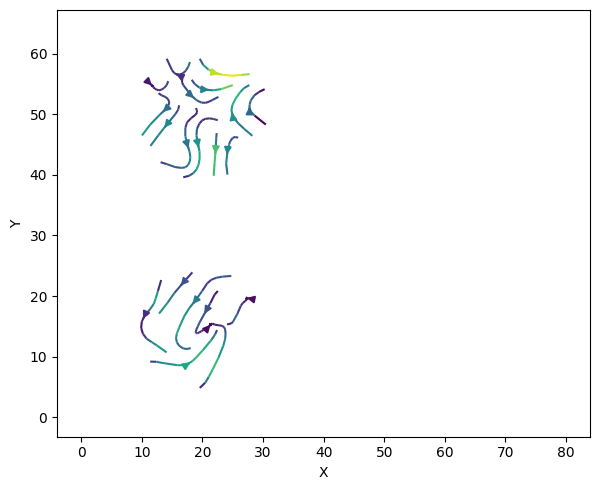

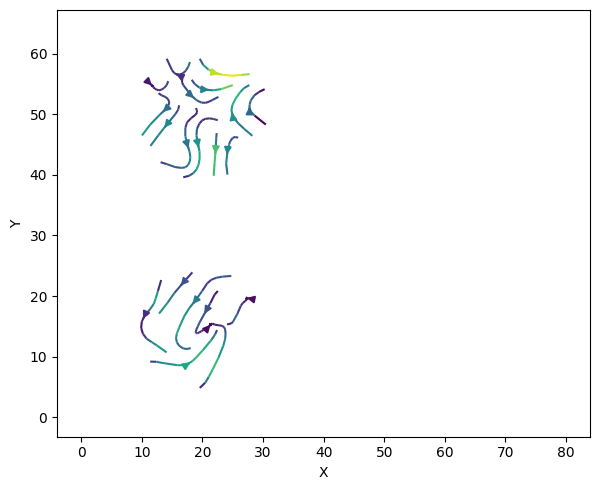

In [13]:
plot(velocity_fit)

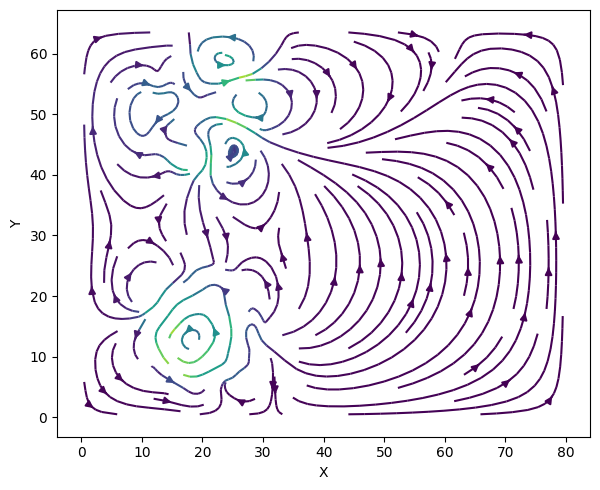

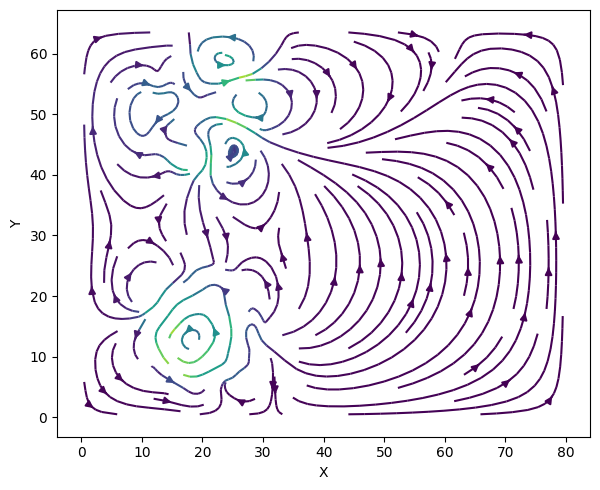

In [12]:
plot(v_trj.iter[0])

In [ ]:
plot(loss_trj.iter.as_spatial(), size=(3, 3), title="Loss")

In [ ]:
plot(control_area, v_trj, overlay='args', animate='iter', frame_time=200, size=(5, 4))